# Deep riccy project

## Env creation

In [1]:
from google.colab import drive
drive.mount('/content/drive')

! tar -zxf /content/drive/MyDrive/Uni/DeepRiccy/refcocog.tar.gz
! pip3 install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt  --quiet
! pip install ftfy regex tqdm --quiet
! pip install git+https://github.com/openai/CLIP.git --quiet
! pip install rouge-metric --quiet

local_path = '/content/refcocog/images/'
local_annotations = '/content/refcocog/annotations/'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-xkqzr_5r
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-xkqzr_5r
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369398 sha256=70b52996e99fd48705afda5ce28e006500ac874d0a3de89fd48dce766597c658
  Stored in directory: /tmp/pip-ephem-wheel-cache-whfouc8

In [2]:
#imports

import json
import pickle
import torch
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from pkg_resources import packaging
import clip
import numpy as np

import os
import skimage
import IPython.display

from collections import OrderedDict
import torch
import torchmetrics as tm

## Baseline

### Utilities

In [3]:
def split_string(string):
    string = string.split("_")
    string = string[:-1]
    string = "_".join(string)
    append = ".jpg"
    string = string + append
    
    return string

In [5]:
def convert_bbox(bbox, img):
  x1, y1, width, height = bbox
  x2, y2 = x1 + width, y1 + height

  # Verify coordinates
  if x1 < 0 or y1 < 0 or x2 > img.width or y2 > img.height:
      print("Bounding box fuori dai limiti dell'immagine!")
  else:
    return x1, y1, x2, y2

### Metrics

In [6]:
class Metrics:
    def __init__(self, model):
        self.iou = tm.IoU()
        self.recall = tm.Recall(iou_threshold=0.5)
        self.model = model

    def update(self, predicted_bbox, target_bbox, image):
      predicted_bbox = torch.tensor(predicted_bbox)
      target_bbox = torch.tensor(target_bbox)
      image_tensor = torch.tensor(image)

      with torch.no_grad():
          predicted_embedding = self.model.encode_image(image_tensor)
          target_embedding = self.model.encode_image(image_tensor)

      cosine_similarity = torch.nn.functional.cosine_similarity(predicted_embedding, target_embedding)
      euclidean_distance = torch.nn.functional.pairwise_distance(predicted_embedding, target_embedding)
      self.iou.update(predicted_bbox, target_bbox)
      self.recall.update(predicted_bbox, target_bbox)
      self.cosine_similarity.update(cosine_similarity)
      self.euclidean_distance.update(euclidean_distance)

    def to_string(self):
        mean_iou = self.iou.compute()
        recall_at_05_iou = self.recall.compute()
        mean_cosine_similarity = self.cosine_similarity.compute()
        mean_euclidean_distance = self.euclidean_distance.compute()

        return f"Mean IoU: {mean_iou:.4f}, Recall@0.5 IoU: {recall_at_05_iou:.4f}, Mean Cosine Similarity: {mean_cosine_similarity:.4f}, Mean Euclidean Distance: {mean_euclidean_distance:.4f}"

    def reset(self):
        self.iou.reset()
        self.recall.reset()
        self.cosine_similarity.reset()
        self.euclidean_distance.reset()


### Dataset

In [7]:
class Coco(Dataset):
    def __init__(self, path_json, path_pickle, train=True):
        self.path_json = path_json
        self.path_pickle = path_pickle
        self.train = train

        #load images and annotations
        with open(self.path_json) as json_data:
            data = json.load(json_data)
            self.ann_frame = pd.DataFrame(data['annotations'])
            self.ann_frame = self.ann_frame.reset_index(drop=False)


        #load annotations
        with open(self.path_pickle, 'rb') as pickle_data:
            data = pickle.load(pickle_data)
            self.refs_frame = pd.DataFrame(data)

        #separate each sentence in dataframe
        self.refs_frame = self.refs_frame.explode('sentences')

        self.refs_frame = self.refs_frame.reset_index(drop=False)

        self.size = self.refs_frame.shape[0]

        self.dataset = pd.merge(self.refs_frame, self.ann_frame, left_on='ann_id', right_on='id')
        self.dataset = self.dataset.drop(columns=['segmentation', 'id', 'category_id_y','ref_id', 'index_x', 'iscrowd', 'image_id_y', 'image_id_x', 'category_id_x', 'ann_id', 'sent_ids', 'index_y', 'area'])

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return self.dataset.iloc[idx]

    def get_annotation(self, idx):
      return self.ann_frame.iloc[idx]
    
    def get_imgframe(self, idx):
      return self.img_frame.iloc[idx]

    def get_validation(self):
        #return the dataframe that has as attribute the validation
        return self.dataset[self.dataset['split'] == 'val']
    
    def get_test(self):
        #return the dataframe that has as attribute the test
        return self.dataset[self.dataset['split'] == 'test']
    
    def get_train(self):
        #return the dataframe that has as attribute the train
        return self.dataset[self.dataset['split'] == 'train']


In [8]:
#test dataset

dataset = Coco(local_annotations + 'instances.json', local_annotations + "refs(umd).p")

print(len(dataset))

95010


In [9]:
dataset.dataset

,split,sentences,file_name,bbox
0,test,"{'tokens': ['the', 'man', 'in', 'yellow', 'coa...",COCO_train2014_000000380440_491042.jpg,"[374.31, 65.06, 136.04, 201.94]"
1,test,"{'tokens': ['skiier', 'in', 'red', 'pants'], '...",COCO_train2014_000000380440_491042.jpg,"[374.31, 65.06, 136.04, 201.94]"
2,test,"{'tokens': ['there', 'is', 'red', 'colored', '...",COCO_train2014_000000419645_398406.jpg,"[93.95, 83.29, 504.61, 290.57]"
3,test,"{'tokens': ['a', 'shiny', 'red', 'vintage', 'p...",COCO_train2014_000000419645_398406.jpg,"[93.95, 83.29, 504.61, 290.57]"
4,test,"{'tokens': ['a', 'apple', 'desktop', 'computer...",COCO_train2014_000000478885_124383.jpg,"[338.8, 82.19, 147.34, 157.37]"
...,...,...,...,...
95005,train,"{'tokens': ['the', 'larger', 'banana', 'is', '...",COCO_train2014_000000003518_1042682.jpg,"[141.7, 20.68, 359.02, 144.57]"
95006,train,"{'tokens': ['a', 'guy', 'in', 'black', 'jacket...",COCO_train2014_000000302199_473946.jpg,"[141.34, 86.71, 115.33, 288.75]"
95007,train,"{'tokens': ['the', 'man', 'in', 'the', 'dark',...",COCO_train2014_000000302199_473946.jpg,"[141.34, 86.71, 115.33, 288.75]"
95008,train,"{'tokens': ['a', 'person', 'in', 'red', 'dress...",COCO_train2014_000000573297_472971.jpg,"[31.71, 67.03, 352.29, 572.97]"


### Model

In [21]:
class VisualGrounding(torch.nn.Module):
    def __init__(self, yolo_version, clip_version, local_path, img_path):
        super(VisualGrounding, self).__init__()
        self.local_path = local_path
        self.img_path = img_path
        #initialize models
        self.yolo = torch.hub.load('ultralytics/yolov5', yolo_version , pretrained=True)
        self.clip, self.preprocess = clip.load(clip_version)
        
        #define metrics
        self.metrics = Metrics()
        
    
    def forward(self, img_path, sentence):
      max_similarity = 0
      max_image = None
      max_bbox = None

      yolo_output = self.yolo(self.local_path+img_path)

      original_img = Image.open(self.local_path+img_path).convert("RGB")

      for i in range(len(yolo_output.xyxy[0])):
          x1 = yolo_output.xyxy[0][i][0].cpu().numpy()
          x1 = np.rint(x1)
          y1 = yolo_output.xyxy[0][i][1].cpu().numpy()
          y1 = np.rint(y1)
          x2 = yolo_output.xyxy[0][i][2].cpu().numpy()
          x2 = np.rint(x2)
          y2 = yolo_output.xyxy[0][i][3].cpu().numpy()
          y2 = np.rint(y2)

          img_cropped = original_img.crop((x1, y1, x2, y2))

          img = self.preprocess(img_cropped).cuda().unsqueeze(0)
          text = clip.tokenize([sentence]).cuda()

          with torch.no_grad():
              image_features = self.clip.encode_image(img).float()
              text_features = self.clip.encode_text(text).float()

          image_features /= image_features.norm(dim=-1, keepdim=True)
          text_features /= text_features.norm(dim=-1, keepdim=True)
          similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

          if similarity > max_similarity:
              max_similarity = similarity
              max_image = img_cropped
              max_bbox = yolo_output.xyxy[0][i]

          return max_bbox, max_image

        
    def evaluate(self, img_path, sentence, gt, original_img):
      bbox = convert_bbox(gt, original_img)
      gt_crop = original_img.crop(bbox)
      prediction_bbox, prediction_img = self.forward(img_path, sentence)
      self.metrics.update(prediction_bbox, bbox, prediction_img, gt_crop)
      return prediction_bbox, prediction_img

    def get_metrics(self):
      return self.metrics.get()
    
    def reset_metrics(self):
      self.metrics.reset()
          
        

### Model evaluation

In [11]:
dataset = Coco(local_annotations + 'instances.json', local_annotations + "refs(umd).p")

In [22]:
model = VisualGrounding('yolov5x','ViT-B/32', local_path, local_annotations)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-5-9 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)



requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


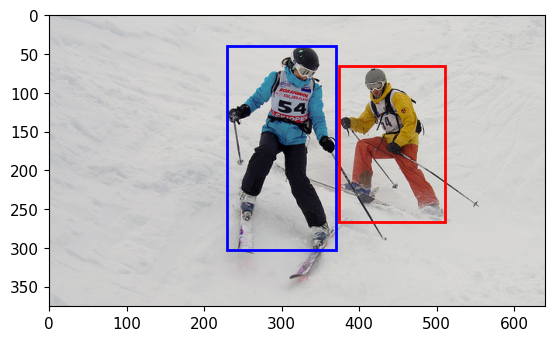

Iteration:  0
(0.0032757957925080993, 0.0)


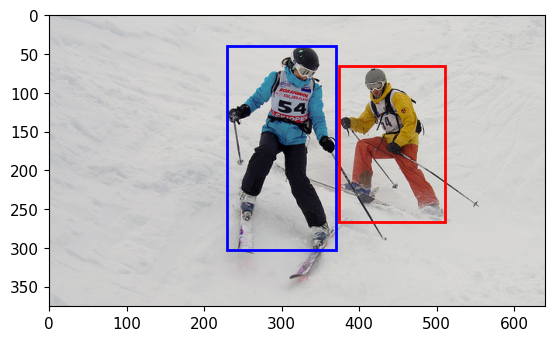

TypeError: ignored

In [24]:
#evaluation of the model
for i in range(0, 101):
    input = dataset[i]
    image_path = split_string(input["file_name"])
    sentence = input["sentences"]["raw"]
    gt = input["bbox"]
    original_img = Image.open(local_path + image_path).convert("RGB")
    # print img dimensions and box coordinates
    bbox, img = model.evaluate(image_path, sentence, gt, original_img)
    if model.get_metrics()[1] < 0.10:
        %matplotlib inline
        plt.imshow(original_img)
        x1, y1, width, height = gt
        x2, y2 = x1 + width, y1 + height
        plt.gca().add_patch(plt.Rectangle((x1, y1), width, height, fill=False, edgecolor='red', linewidth=2))
        bbox_cpu = bbox.cpu()  # Move the CUDA tensor to CPU
        plt.gca().add_patch(plt.Rectangle((bbox_cpu[0], bbox_cpu[1]), bbox_cpu[2] - bbox_cpu[0], bbox_cpu[3] - bbox_cpu[1], fill=False, edgecolor='blue', linewidth=2))
        plt.show()


    if i % 20 == 0:
        print("Iteration: ", i)
        print(model.get_metrics())
        